In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt

import torch, torchvision
from cleanlab.models.mnist_pytorch import CNN, MNIST_TEST_SIZE, MNIST_TRAIN_SIZE
import cleanlab
import numpy as np
from PIL import Image

import sys
import os
import traceback
from datetime import datetime as dt
import copy

from sklearn.metrics import confusion_matrix, accuracy_score

# Important! Make fonts Type I fonts (necessary for publishing in ICML and other conference)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from torchvision import datasets

/home/cgn/Dropbox (MIT)/cgn/cleanlab/cleanlab/util.py:397: UserWarning: 
        pyTorch supports Python version 2.7, 3.5, 3.6, 3.7.
        cleanlab supports Python versions 2.7, 3.4, 3.5, 3.6.
        You are using Python version 3.7.
        You'll need to use a version compatible with both.
  warnings.warn(warning)


In [2]:
# Download MNIST and set-up train/test/labels

X_train = np.arange(MNIST_TRAIN_SIZE)
X_test = np.arange(MNIST_TEST_SIZE)
# X_train = X_train[X_train % 10 == 0]
y_train = datasets.MNIST('../data', train=True, download=True).train_labels.numpy()
y_test = datasets.MNIST('../data', train=False, download=True).test_labels.numpy()
py_train = cleanlab.util.value_counts(y_train) / float(len(y_train))
X_train_data = datasets.MNIST('../data', train=True).train_data.numpy()

  0%|          | 16384/9912422 [00:00<01:13, 134584.95it/s]

9920512it [00:00, 32194691.86it/s]                           


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 897941.68it/s]
1654784it [00:00, 11345334.39it/s]                           

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



8192it [00:00, 378182.14it/s]
/home/cgn/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/cgn/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/home/cgn/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [10]:
Image.show

AttributeError: module 'PIL.Image' has no attribute 'show'

In [37]:
x.save('mnist_train_40144.pdf')

In [33]:
y_train[40144]

5

In [36]:
x = Image.fromarray(255 - X_train_data[40144], )

## Finding label errors in MNIST training set

In [9]:
def imshow(inp, img_labels=None, img_pred=None, img_fns = None, figsize=(10,10), normalize=False, method_name = '', savefig = False):
    """Imshow for Tensor."""
    height, width = inp.shape[1:]
    xbins = 8
    ybins = int(np.ceil(len(img_labels)/xbins))
    xbin_width = width // xbins
    ybin_height = height // ybins
    
    inp = inp.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    
    ax = plt.figure(figsize=figsize).gca()
    ax.imshow(inp)
    pad_size = (8-len(img_pred)%8)%8
    img_labels = img_labels + ['']*pad_size #padding
    img_pred = img_pred + ['']*pad_size #padding
    img_fns = img_fns + ['']*pad_size #padding
#     grid = np.asarray(img_labels).reshape((ybins, xbins))
       
    num_red_boxes = 0
    for (j,i),idx in np.ndenumerate(np.arange(ybins*xbins).reshape((ybins, xbins))):
        prediction = img_pred[idx]
        label = img_labels[idx]
        img_fn = img_fns[idx]
        image_index = int(img_fn[13:])
        
        plt.hlines([j*ybin_height - .5], xmin=i*xbin_width, xmax=i*xbin_width + xbin_width, color = 'lightgray', linewidth=2)
        
        fontsize=max(min(1.4*figsize[0], .9*figsize[0]-.7*len(prediction)), 12) if prediction != '' else 1
        tt = ax.text(i*xbin_width + xbin_width/2,j*ybin_height + ybin_height/20,prediction,ha='center',va='center', fontsize=fontsize)
        tt.set_bbox(dict(facecolor='lime', alpha=0.8, edgecolor=None))
        
        fontsize=min(.5*figsize[0], 1.25*figsize[0]-len(img_fn)) if img_fn != '' else 1
        tt = ax.text(i*xbin_width + xbin_width/2.8,j*ybin_height + ybin_height/7,img_fn,ha='center',va='center', fontsize=fontsize)
        tt.set_bbox(dict(facecolor='lightgray', alpha=0.8, edgecolor=None))
        
        fontsize=max(min(1.4*figsize[0], .9*figsize[0]-.7*len(label)),12) if label != '' else 1
        t = ax.text(i*xbin_width + xbin_width/2,j*ybin_height + ybin_height/10*9,label,ha='center',va='center', fontsize=fontsize)
        t.set_bbox(dict(facecolor='cyan', alpha=0.8, edgecolor=None))
        
        
        if image_index in [21601, 40466, 29922, 40144, 51248, 43454, 59915, 57662, 25678, 2676, 24798, 31727, 7080, 26560, 10994, 53396, 54264]:#, 59701, 42566, 26940, 47759
            # Draw red bounding box
            plt.hlines([j*ybin_height + 0.5,(j+1)*ybin_height - 1.5], xmin=i*xbin_width - 0.3, xmax=i*xbin_width + xbin_width - 0.65, color = 'red', linewidth=15)
            plt.vlines([i*xbin_width + 0.5,(i+1)*xbin_width - 1.5], ymin=j*ybin_height + 0.5, ymax=j*ybin_height + ybin_height - 0.5, color = 'red', linewidth=15)
            num_red_boxes += 1
    
    print("Number of red boxes:", num_red_boxes)
    plt.axis('off')
    if savefig:
        plt.savefig('figs/mnist_training_label_errors'+str(len(img_pred))+"_"+method_name+'.pdf', pad_inches=0.0, bbox_inches='tight')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
methods = ['prune_by_class', 'prune_by_noise_rate', 'both'] # methods for selecting noise

In [ ]:
%%time
# Constants
savefig = False
max_images = 24
seed = 43

# Pre-train
np.random.seed(43)
cnn = CNN(epochs=50, log_interval=None, loader='train') #pre-train
cnn.fit(X_train, y_train, loader='train') # pre-train (overfit, not out-of-sample) to entire dataset.

# Out-of-sample cross-validated holdout predicted probabilities
np.random.seed(4)
cnn.epochs = 1 # Single epoch for cross-validation (already pre-trained)   
cj, psx = cleanlab.latent_estimation.estimate_confident_joint_and_cv_pred_proba(X_train, y_train, clf=cnn, )
est_py, est_nm, est_inv = cleanlab.latent_estimation.estimate_latent(cj, y_train)

In [11]:
est_py.round(2)

array([0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.09, 0.1 , 0.1 , 0.1 , 0.1 ])

In [18]:
ordered_noise_idx

array([33, 26,  1, 12, 27, 24, 30, 13, 11, 29,  0, 14, 19, 18, 25,  2,  8,
       32,  4, 31,  7,  5,  6, 28, 21,  3, 22, 20, 15,  9, 17, 10, 16, 23])

Method: prune_by_class
Number of estimated errors in training set: 43
Number of red boxes: 4


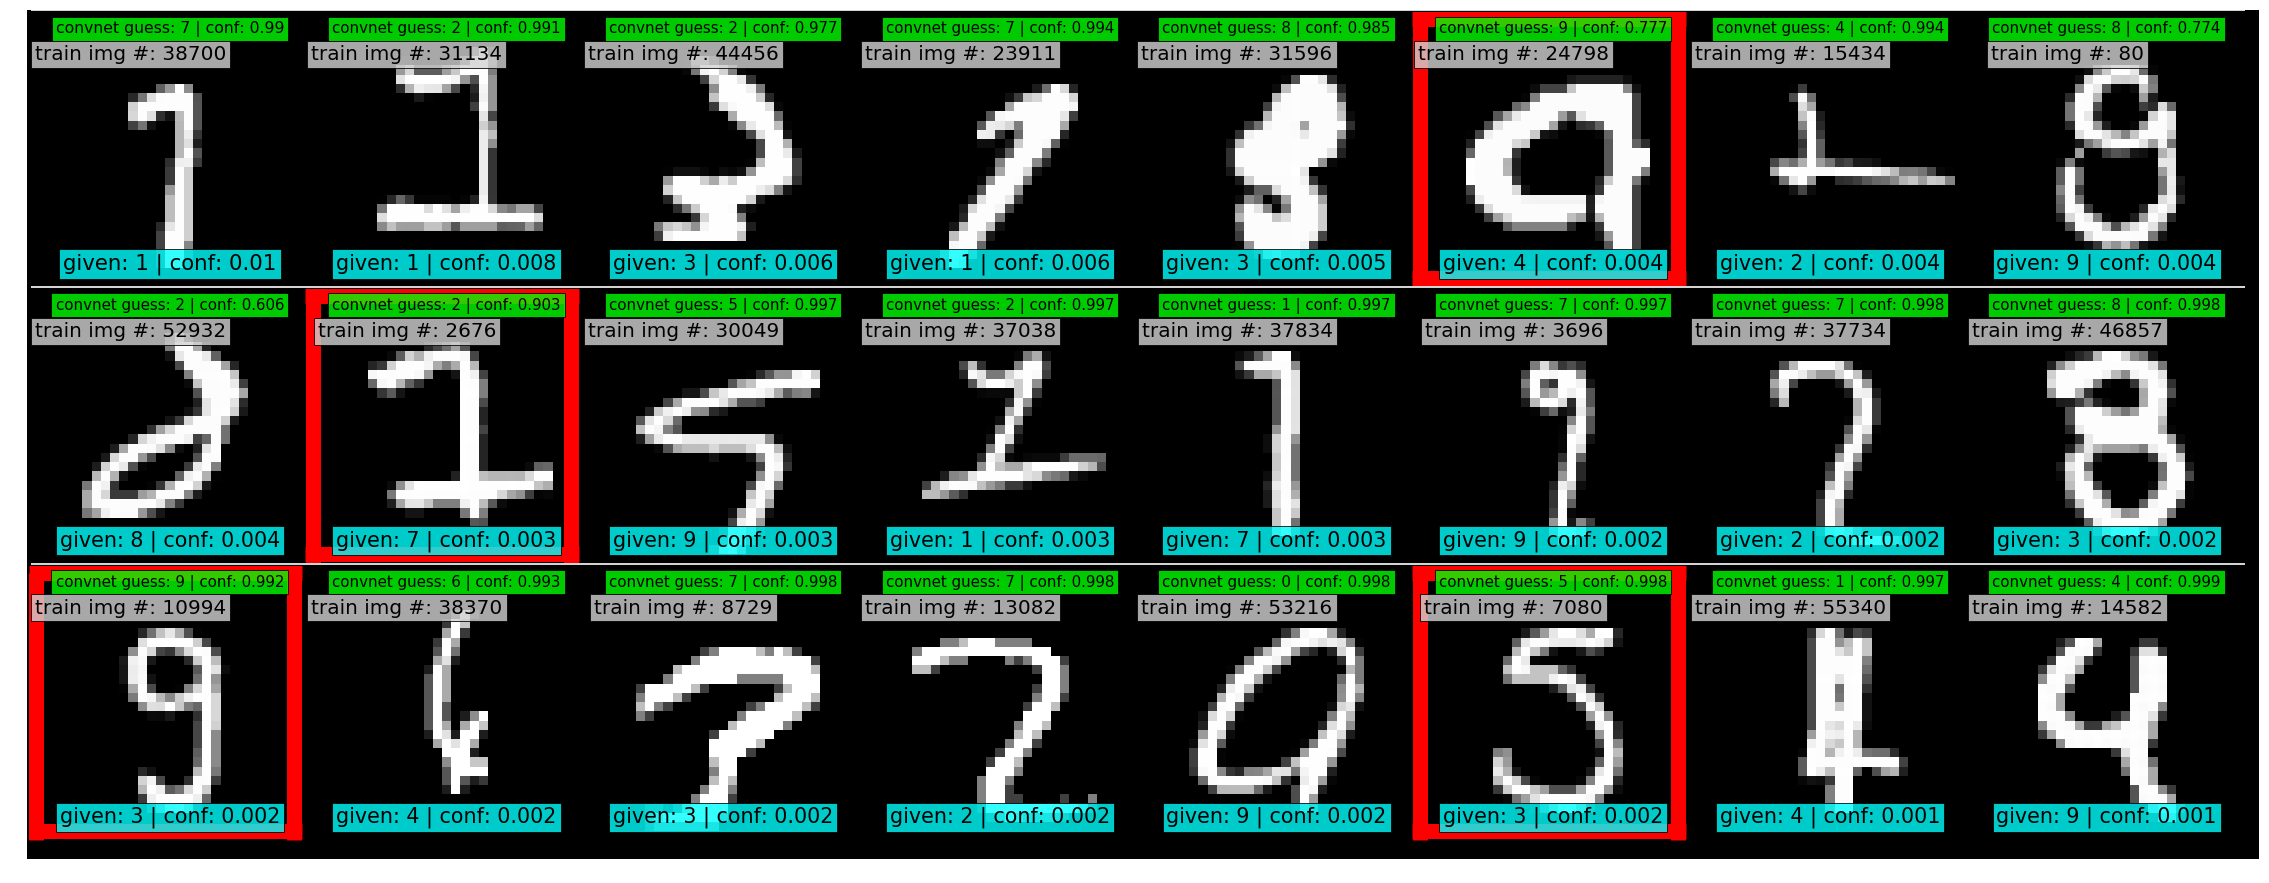

Method: prune_by_noise_rate
Number of estimated errors in training set: 42
Number of red boxes: 3


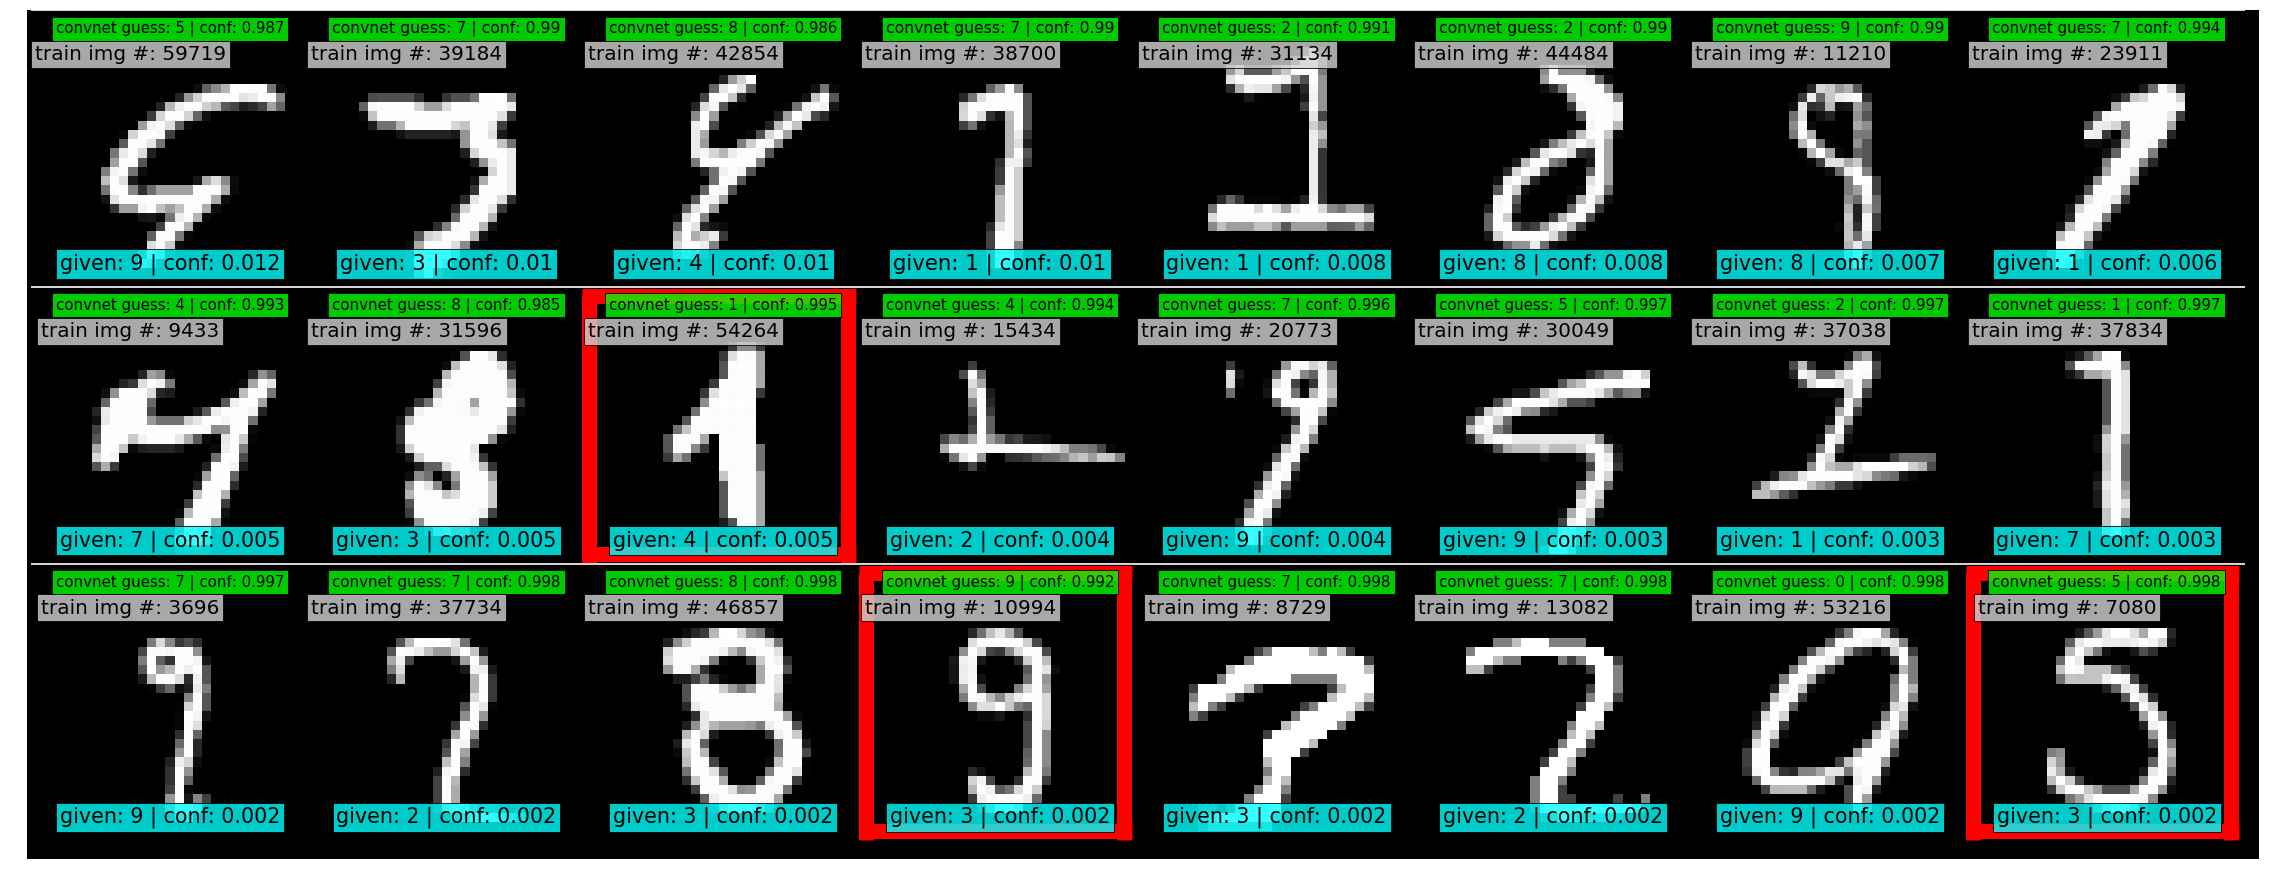

Method: both
Number of estimated errors in training set: 34
Number of red boxes: 2


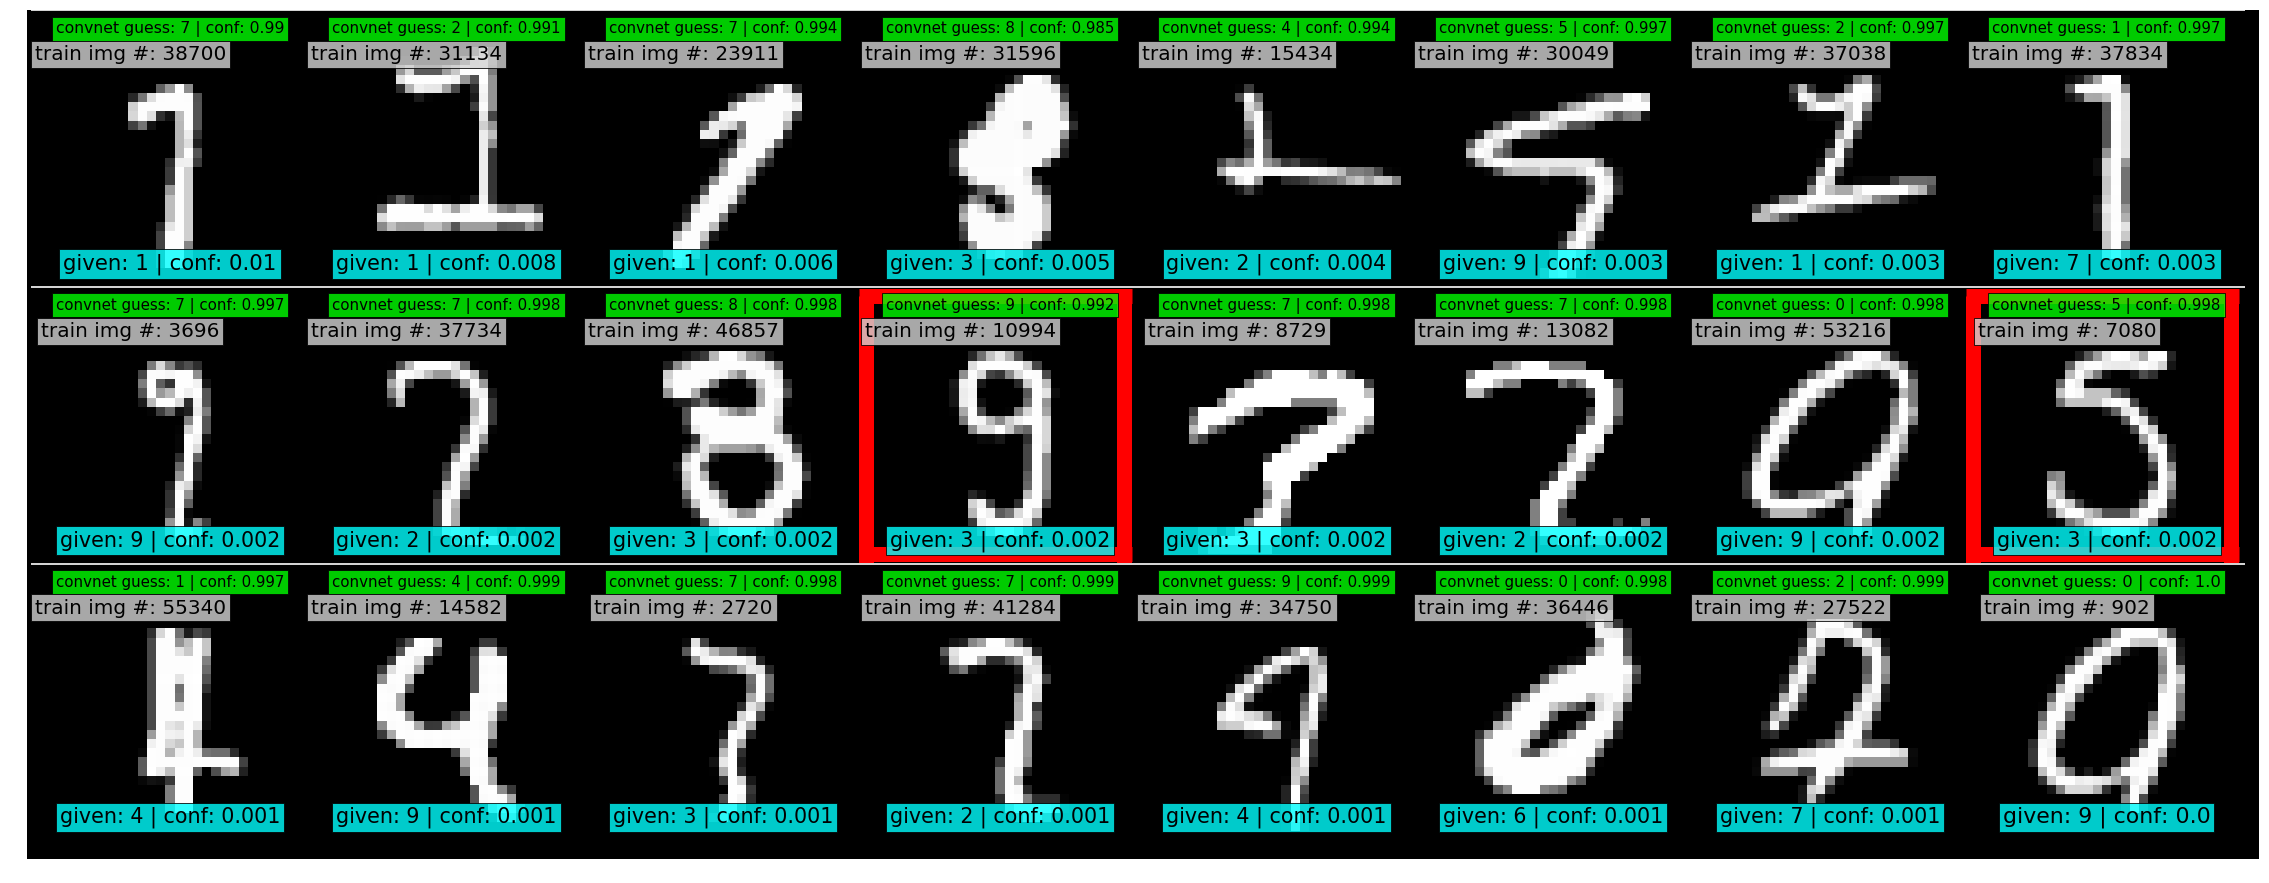

In [19]:
for method in methods:
    print('Method:', method)
    noise_idx = cleanlab.pruning.get_noise_indices(y_train, psx, est_inv, prune_method=method, confident_joint=cj)
    print('Number of estimated errors in training set:', sum(noise_idx))
    pred = np.argmax(psx, axis=1)

    # Prepare and display figure ordered by lowest predicted probability
    if sum(noise_idx) >= max_images:
        ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx])[::-1]
    #     ordered_noise_idx = np.argsort(np.asarray([psx[idx,y_train[idx]] - psx[idx,pred[idx]] for idx in range(len(y_train)) ])[noise_idx]) # order by difference in predicted prob and given label prob

        prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx][ordered_noise_idx][:max_images]
        prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
        img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
        label4viz = y_train[noise_idx][ordered_noise_idx][:max_images]
        pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

        graphic = torchvision.utils.make_grid(torch.from_numpy(np.concatenate([X_train_data[img_idx][:, None]]*3, axis=1)))
        img_labels = ["given: "+str(label4viz[w])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
        img_pred = ["convnet guess: "+str(pred4viz[w])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]
        img_fns = ["train img #: " + str(item) for item in img_idx]
        
        # Display image
        imshow(
            graphic, 
            img_labels = img_labels, 
            img_pred = img_pred, 
            img_fns = img_fns, 
            figsize = (40,max_images/1.1), 
            method_name = method, 
            savefig = savefig,
        )
        plt.show()
    else:
        print('max_images is too large. Not enough images to display.')

## Show the result generalizes for different seed values.

In [ ]:
# Initialize constants
max_images = 24
np.random.seed(43)
prune_method = 'prune_by_noise_rate'

# Pre-train
cnn = CNN(epochs=15, log_interval=None, loader='train') #pre-train
cnn.fit(X_train, y_train, loader='train') # pre-train (overfit, not out-of-sample) to entire dataset.
params = cnn.model.state_dict() # store CNN's weights after pretraining

cnn.epochs = 1 # Single epoch for cross-validation (already pre-trained)   
for seed in range(21,35):    
    np.random.seed(seed)
    cnn.model.load_state_dict(params) 
    cj, psx = cleanlab.latent_estimation.estimate_confident_joint_and_cv_pred_proba(X_train, y_train, clf=cnn, )
    est_py, est_nm, est_inv = cleanlab.latent_estimation.estimate_latent(cj, y_train)
    noise_idx = cleanlab.pruning.get_noise_indices(y_train, psx, est_inv, prune_method=prune_method, confident_joint=cj)
    pred = np.argmax(psx, axis=1)
    print("Random seed:", seed)

    if seed == 32: # print an example seed.
        # Prepare and display figure ordered by lowest predicted probability

        ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx])

        prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx][ordered_noise_idx][:max_images]
        prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
        img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
        label4viz = y_train[noise_idx][ordered_noise_idx][:max_images]
        pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

        graphic = torchvision.utils.make_grid(torch.from_numpy(np.concatenate([X_train_data[img_idx][:, None]]*3, axis=1)))
        # graphic = np.concatenate([graphic[:, None]]*3, axis=1)
        img_labels = ["given: "+str(label4viz[w])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
        img_pred = ["argmax pr ed: "+str(pred4viz[w])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]
        img_fns = ["train img #: " + str(item) for item in img_idx]

        imshow(graphic, img_labels = img_labels, img_pred = img_pred, img_fns = img_fns, figsize=(40,max_images/1.1))
        plt.show()
    

Random seed: 21
Random seed: